In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta 
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from joblib import delayed, Parallel

from core import  do_simulation
from helpers import Params
from const import STATE, COLORS, NUM_STATES,  STATES


In [3]:
DATE_FORMAT = '%d/%m/%Y'

def T(s):
    return datetime.strptime(s, DATE_FORMAT)

In [4]:
df = pd.read_csv('data/wuhan.csv', sep=',')
df['date'] = df['date'].apply(lambda s: datetime.strptime(s, DATE_FORMAT))
# df.head(5)
df

,date,infected,death,cured
0,2020-01-18,4,0,0
1,2020-01-19,17,0,0
2,2020-01-20,136,4,0
3,2020-01-21,60,2,0
4,2020-01-22,62,0,0
5,2020-01-23,70,6,3
6,2020-01-24,77,15,0
7,2020-01-25,46,7,0
8,2020-01-26,80,18,2
9,2020-01-27,892,22,0


# general information

the simulation starts on **Jan 23, 2020**, when the lockdown happened in Wuhan, until **Fen 09, 2020**

In [5]:
start_date = T('27/01/2020')  # T=0
end_date = T('05/02/2020')  #

In [6]:
subdf = df[(df['date'] > start_date) & (df['date'] < end_date)] 

I_true = subdf['infected'].values
O_true = subdf['death'].values + subdf['cured'].values
subdf

,date,infected,death,cured
10,2020-01-28,315,19,0
11,2020-01-29,356,25,7
12,2020-01-30,378,30,21
13,2020-01-31,576,33,36
14,2020-02-01,894,32,32
15,2020-02-02,1033,41,53
16,2020-02-03,1242,48,79
17,2020-02-04,1967,49,65


In [7]:
total_days = subdf.shape[0]
bed_info_raw = [
#     (T('22/01/2020'), 3000), # 3000),
#     (T('25/01/2020'), 1000), # 4000),
    (T('27/01/2020'), 4000),
    (T('31/01/2020'), 6000), # 10000),
    (T('04/02/2020'), 1000), #  11000),
    (T('07/02/2020'), 2000), # 13000)
]
# number of new beds at  some days
bed_info = [((d-start_date).days, n) for d, n in bed_info_raw if d < end_date]
bed_info

[(0, 4000), (4, 6000), (8, 1000)]

In [8]:
alpha_list = np.power(0.1, np.arange(5, 11))
beta_list = np.power(0.1, np.arange(5, 11))

# assumption: alpha > beta
alpha_beta_choices = [
    (alpha,  beta)
    for alpha, beta in product(alpha_list, beta_list)
    if alpha > beta
] 
num_I_list = np.arange(1000, 10001, step=1000)
I2E_factors = np.arange(1, 10.1, step=1)

def one_run(initial_num_I, I2E_factor, alpha, beta):
    initial_num_E = initial_num_I * I2E_factor
    params = Params(
        initial_num_I=initial_num_I,
        initial_num_E=initial_num_E,
        alpha=alpha,
        beta=beta
    )
    total, delta, increase = do_simulation(total_days, bed_info, params)    
    
    I_mse = mean_squared_error(I_true, increase[1:, STATE.I])
    O_mse = mean_squared_error(O_true, increase[1:, STATE.O])
    
    I_mae = mean_absolute_error(I_true, increase[1:, STATE.I])
    O_mae = mean_absolute_error(O_true, increase[1:, STATE.O])

    row = (initial_num_I, initial_num_E, alpha, beta, I_mse, O_mse, I_mae,  O_mae)
    return row
    
total_num_configs = len(num_I_list) * len(alpha_beta_choices) * len(I2E_factors)

rows = Parallel(n_jobs=-1)(
    delayed(one_run)(initial_num_I=num_I, I2E_factor=I2E_factor, alpha=alpha, beta=beta)
    for num_I, I2E_factor, (alpha,  beta) in tqdm(
        product(num_I_list, I2E_factors, alpha_beta_choices), total=total_num_configs
    )
)



100%|██████████| 1500/1500 [00:27<00:00, 54.21it/s]


In [12]:
df = pd.DataFrame(
    rows,
    columns=['initial_num_I', 'initial_num_E', 'alpha', 'beta', 'I_mse', 'O_mse', 'I_mae', 'O_mae']
)
df.tail(10)

,initial_num_I,initial_num_E,alpha,beta,I_mse,O_mse,I_mae,O_mae
1490,10000,100000.0,1.000000e-06,1.000000e-07,1.098566e+12,16527.754409,846043.446617,84.465787
1491,10000,100000.0,1.000000e-06,1.000000e-08,1.097941e+12,16527.754409,845636.966563,84.465787
1492,10000,100000.0,1.000000e-06,1.000000e-09,1.097665e+12,16527.754409,845487.542285,84.465787
1493,10000,100000.0,1.000000e-06,1.000000e-10,1.097638e+12,16527.754409,845472.598340,84.465787
1494,10000,100000.0,1.000000e-07,1.000000e-08,4.000604e+10,16527.754409,134050.464457,84.465787
1495,10000,100000.0,1.000000e-07,1.000000e-09,3.886351e+10,16527.754409,132316.984305,84.465787
1496,10000,100000.0,1.000000e-07,1.000000e-10,3.875007e+10,16527.754409,132143.516955,84.465787
1497,10000,100000.0,1.000000e-08,1.000000e-09,2.323424e+08,16527.754409,14053.936375,84.465787
1498,10000,100000.0,1.000000e-08,1.000000e-10,2.302766e+08,16527.754409,13989.226865,84.465787
1499,10000,100000.0,1.000000e-09,1.000000e-10,1.437323e+08,16527.754409,10928.947603,84.465787


In [13]:
best_row = df.sort_values(by='I_mse').iloc[0]
print(best_row)
best_num_I, best_num_E, best_alpha, best_beta = best_row.initial_num_I, best_row.initial_num_E, best_row.alpha, best_row.beta

# start  at Jan 22, lockdown started on Jan 23
params = Params(
    initial_num_I=best_num_I, initial_num_E=best_num_E, alpha=best_alpha, beta=best_beta
)
total, delta, increase = do_simulation(total_days, bed_info, params)    


initial_num_I    5.000000e+03
initial_num_E    5.000000e+03
alpha            1.000000e-08
beta             1.000000e-09
I_mse            2.290357e+05
O_mse            5.633979e+03
I_mae            3.281430e+02
O_mae            5.268727e+01
Name: 612, dtype: float64


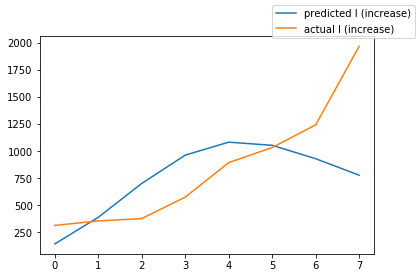

In [15]:
fig, ax = plt.subplots(1, 1)
# for color, s in zip(COLORS, range(NUM_STATES)):
ax.plot(increase[1:, STATE.I])
ax.plot(I_true)
fig.legend(['predicted I (increase)', 'actual I (increase)'])